In [1]:
# use new_torch_env to get cv2

import os

import numpy as np
import pandas as pd
import seaborn as sns

import cv2
import matplotlib.pyplot as plt

import pickle

In [4]:
def standardize(dict_of_dfs):

    for att in dict_of_dfs.keys():
        dict_of_dfs[att]['s_lsr'] = (dict_of_dfs[att]['lsr_mean'] - dict_of_dfs[att]['lsr_mean'].mean())/dict_of_dfs[att]['lsr_mean'].std()
        dict_of_dfs[att]['s_mm'] = (dict_of_dfs[att]['mm_mean'] - dict_of_dfs[att]['mm_mean'].mean())/dict_of_dfs[att]['mm_mean'].std()


In [5]:
def get_ens_df():

    file_name1 = 'dict_of_dfs1.pkl'

    with open(file_name1, 'rb') as file:      
        dict_of_dfs1 = pickle.load(file)

    # file_name2 = 'dict_of_dfs2.pkl'

    # with open(file_name2, 'rb') as file:      
    #     dict_of_dfs2 = pickle.load(file)

    file_name3 = 'dict_of_dfs3.pkl'

    with open(file_name3, 'rb') as file:      
        dict_of_dfs3 = pickle.load(file)


    standardize(dict_of_dfs1)
    standardize(dict_of_dfs3)

    dict_of_ens_dfs = {}

    for att in dict_of_dfs1.keys(): # same keys in all dicts of dfs.
        
        dict_of_dfs1[att].rename(columns = {'s_lsr': 's_lsr1', 's_mm':'s_mm1'}, inplace = True)
        #dict_of_dfs2[att].rename(columns = {'s_lsr': 's_lsr2', 's_mm':'s_mm2'}, inplace = True)
        dict_of_dfs3[att].rename(columns = {'s_lsr': 's_lsr3', 's_mm':'s_mm3'}, inplace = True)


        temp_df = pd.merge(dict_of_dfs1[att], dict_of_dfs3[att], on = 'img', how = 'inner') # remember to merge w/ 2
        temp_df['ens_score'] = temp_df[['s_lsr1', 's_mm1', 's_lsr3', 's_mm3']].mean(axis=1)
        ens_df = temp_df[['img','ens_score', 's_lsr1', 's_mm1', 's_lsr3', 's_mm3']]

        dict_of_ens_dfs[att] = ens_df

    return(dict_of_ens_dfs)

In [ ]:
def check_corr(dict_of_ens_dfs, simple_version = True):
    plt.figure(figsize = [15,20])

    for i, att in enumerate(dict_of_ens_dfs.keys()):

        plt.subplot(5, 2, i+1)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
        #plt.yticks(rotation=90)

        if simple_version == True:
            sub_df = dict_of_ens_dfs[att][['img', 'ens_score']].copy()
            sub_df['annotater1'] = dict_of_ens_dfs[att][['s_lsr1', 's_mm1']].mean(axis  = 1)
            # sub_df['annotater2'] = dict_of_ens_dfs[att][['s_lsr2', 's_mm2']].mean(axis  = 1)
            sub_df['annotater3'] = dict_of_ens_dfs[att][['s_lsr3', 's_mm3']].mean(axis  = 1)

            sns.heatmap(sub_df.corr(), vmin=-1, vmax=1, cmap = "RdYlBu_r", annot = True)
            fig_path = f'plots/simple_corr_plot.pdf'

        elif simple_version == False:
            sns.heatmap(dict_of_ens_dfs[att].corr(), vmin=-1, vmax=1, cmap = "RdYlBu_r", annot = True)
            fig_path = f'plots/_corr_plot.pdf'
        
        else:
            print('wrong input')
        
        plt.title(att)

    suptitle = f'corr between anotaters and the ensamble'
    plt.suptitle(suptitle, size=16)
    plt.savefig(fig_path, bbox_inches="tight")    
    
    plt.show()

In [ ]:
def plot_sample(dict_of_dfs, att, measure, sample = 'top'):

    n = 16
    #measure = 'ens_score'

    if sample == 'top':
        sample_img = dict_of_dfs[att].sort_values(measure, ascending = False)['img'][0:n].values
        scores = dict_of_dfs[att].sort_values(measure, ascending = False)[measure][0:n].values
    
    elif sample == 'bottom':
        sample_img = dict_of_dfs[att].sort_values(measure, ascending = True)['img'][0:n].values
        scores = dict_of_dfs[att].sort_values(measure, ascending = True)[measure][0:n].values

    
    elif sample == 'radom':
        sample_img = dict_of_dfs[att].sort_values(measure, ascending = True)['img'].sample(n).values
        scores = dict_of_dfs[att].sort_values(measure, ascending = True)[measure].sample(n).values

    else:
        print('wrong input')


    imgs_dir = '/media/simon/Seagate Expansion Drive/images_spanner'

    plt.figure(figsize = [15,10])
    for i, j in enumerate(sample_img):

        path_image = os.path.join(imgs_dir, j)

        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
            
        img = cv2.imread(path_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correcting the colors:
        plt.imshow(img)
        #plt.xticks([])
        #plt.yticks([])
        plt.title(f'{j}, {measure.split("_")[0]} = {scores[i]:.3f}')

    suptitle = f'{att}, {sample} {n} images'
    plt.suptitle(suptitle, size=16)

    fig_path = f'plots/{att}_{measure}_{sample}_{n}.pdf'
    plt.savefig(fig_path, bbox_inches="tight")    

    plt.show()

In [ ]:
def loop_plot(dict_of_dfs, measure):

    for att in dict_of_dfs.keys():

        plot_sample(dict_of_dfs, att, measure, sample='top')
        plot_sample(dict_of_dfs, att, measure, sample='bottom')

In [6]:
dict_of_ens_dfs  = get_ens_df()

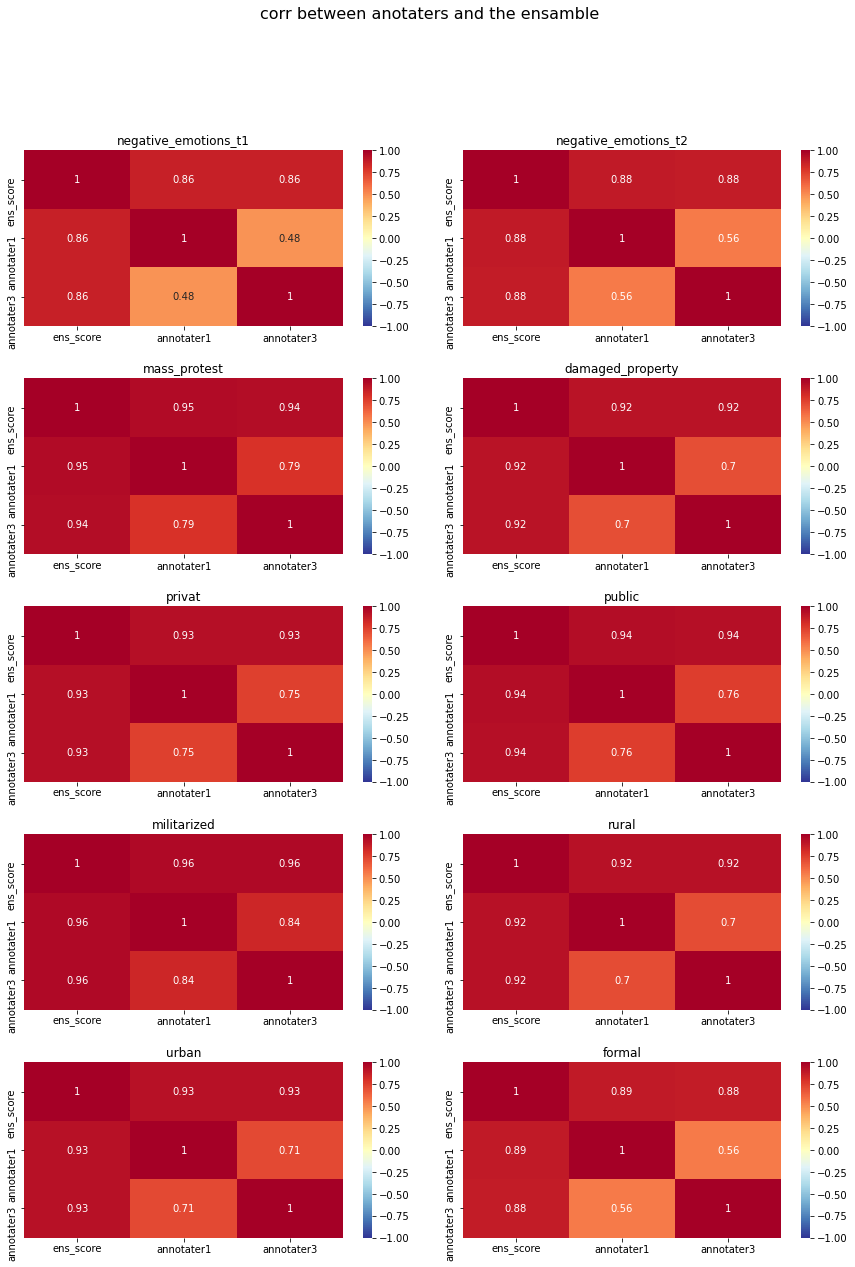

In [15]:
check_corr(dict_of_ens_dfs, simple_version=True)

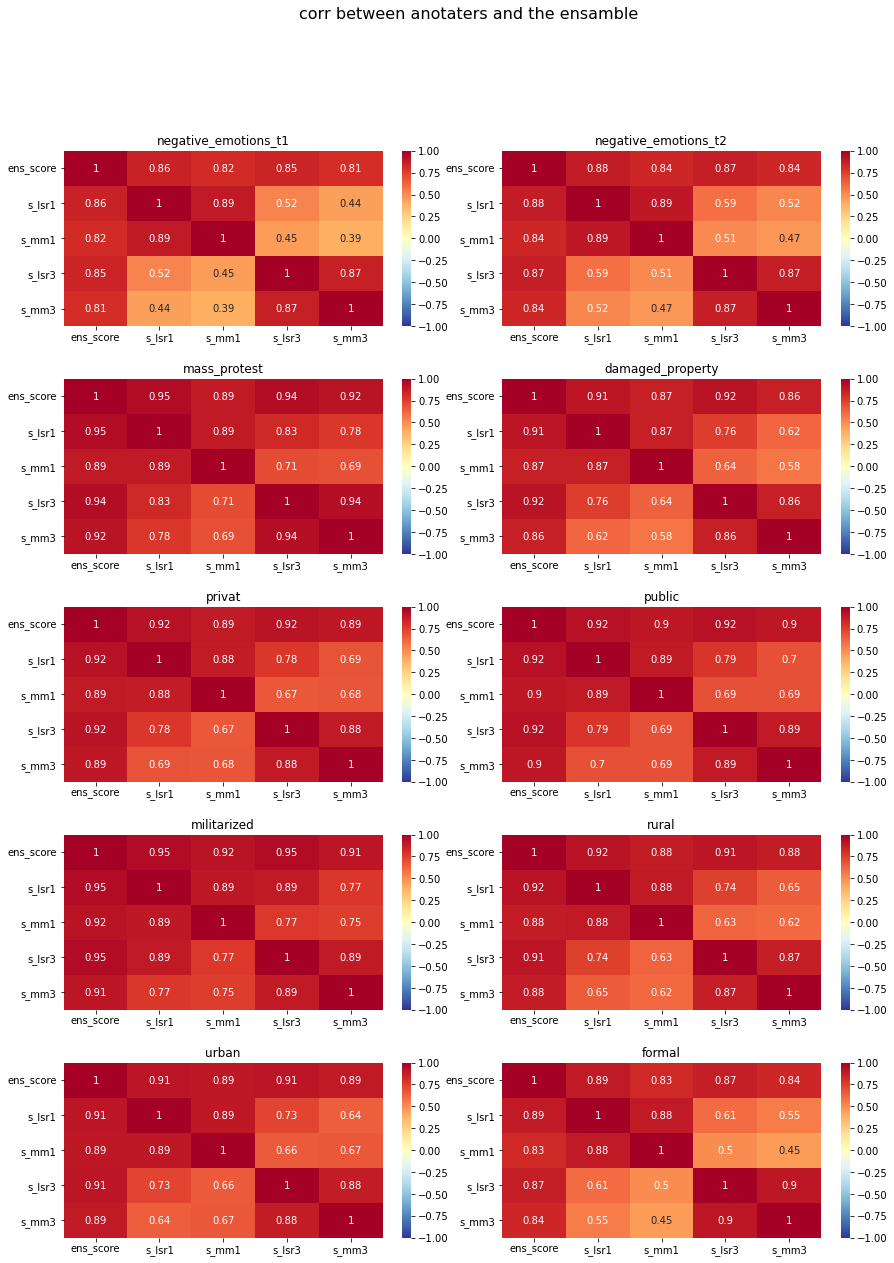

In [12]:
check_corr(dict_of_ens_dfs, simple_version=False)

In [ ]:
print('annotater 1')
loop_plot(dict_of_ens_dfs, 's_lsr1')

# print('annotater 2')
# loop_plot(dict_of_ens_dfs, 's_lsr_2')

print('annotater 3')
loop_plot(dict_of_ens_dfs, 's_lsr_3')

print('ensample')
loop_plot(dict_of_ens_dfs, 'ens_score')